In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import xgboost as xgb
import sklearn
import optuna
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
def standarize_dataframe(df,columns):
    df = df[columns]
    df.columns = list(tess_dict.keys())

    return  df

k2_dict = {
    "id": "tic_id",
    "ra": "ra",
    "dec": "dec",
    "teff": "st_teff",
    "radius": "st_rad",
    "logg": "st_logg",
    "period": "pl_orbper",
    "transit_time_t0": "pl_tranmid",
    "planet_radius": "pl_rade",
    "duration": "pl_trandur",
    "depth": "pl_trandep",
    "insolation": "pl_insol",
    "temperature": "pl_eqt",
    "planet_count": "sy_pnum",
    "disposition": "disposition"
}

tess_dict = {
    "id": "tid",
    "ra": "ra",
    "dec": "dec",
    "teff": "st_teff",
    "radius": "st_rad",
    "logg": "st_logg",
    "period": "pl_orbper",
    "transit_time_t0": "pl_tranmid",
    "planet_radius": "pl_rade",
    "duration": "pl_trandurh",
    "depth": "pl_trandep",
    "insolation": "pl_insol",
    "temperature": "pl_eqt",
    "planet_count": "pl_pnum",
    "disposition": "tfopwg_disp"
}

kepler_dict = {
    "id": "kepid",
    "ra": "ra",
    "dec": "dec",
    "teff": "koi_steff",
    "radius": "koi_srad",
    "logg": "koi_slogg",
    "period": "koi_period",
    "transit_time_t0": "koi_time0bk",
    "planet_radius": "koi_prad",
    "duration": "koi_duration",
    "depth": "koi_depth",
    "insolation": "koi_insol",
    "temperature": "koi_teq",
    "planet_count": "koi_count",
    "disposition": "koi_pdisposition"
}


In [3]:
k2 = pd.read_csv('/kaggle/input/nasa-observations/k2.csv')
kepler = pd.read_csv('/kaggle/input/nasa-observations/kepler.csv')
tess = pd.read_csv('/kaggle/input/nasa-observations/tess.csv')

In [4]:
k2_standarized = standarize_dataframe(k2, list(k2_dict.values()))
kepler_standarized = standarize_dataframe(kepler, list(kepler_dict.values()))
tess_standarized = standarize_dataframe(tess, list(tess_dict.values()))

k2_standarized['depth'] = k2_standarized['depth'] * 10000 # To convert % to ppm units as in the other dataset

/tmp/ipykernel_36/1872233160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k2_standarized['depth'] = k2_standarized['depth'] * 10000 # To convert % to ppm units as in the other dataset


In [5]:
nasa_missions =pd.concat([kepler_standarized,k2_standarized,tess_standarized ], ignore_index=True)

In [6]:
nasa_missions['disposition'].unique()

array(['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED', 'REFUTED', 'FP', 'PC',
       'KP', 'APC', 'FA', 'CP'], dtype=object)

In [7]:
labels = ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED','CP','FP']
nasa_missions_filtered =  nasa_missions[nasa_missions['disposition'].isin(labels)]

replace_dict = {
    'disposition':{
        'CANDIDATE': 'exo_planet',
        'CONFIRMED': 'exo_planet',
        'CP': 'exo_planet',
        'FALSE POSITIVE': 'non_exo_planet',
        'FP': 'non_exo_planet',
    }
}
nasa_missions_filtered = nasa_missions_filtered.replace(replace_dict)

In [8]:
X = nasa_missions_filtered.drop(['id','disposition',"ra","dec","planet_count"], axis=1) # id is not needed
y = nasa_missions_filtered['disposition']

In [13]:
median_inputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imputer = pd.DataFrame(median_inputer.fit_transform(X), columns=X.columns)

In [16]:
scaler = StandardScaler()
X_escaled = scaler.fit_transform(X_imputer)

In [20]:
tsne = TSNE(n_components=2, 
            random_state=42,)
X_tsne = tsne.fit_transform(X_escaled)

In [21]:
tsne_df = pd.DataFrame(data = X_tsne, 
                       columns = ['component_1', 'component_2'])

tsne_df['disposition'] = y.values

AttributeError: module 'matplotlib' has no attribute 'show'

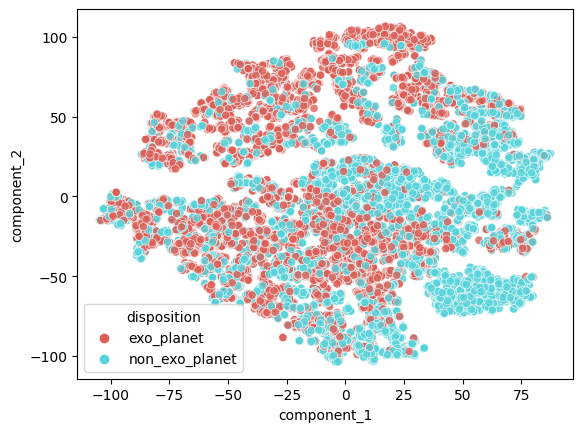

In [26]:
sns.scatterplot(
    x="component_1", y="component_2",
    hue="disposition",
    palette=sns.color_palette("hls", len(np.unique(y.values))),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.show()

The classification looks quite complex D: , but even with outliers isn't too bad, let's try xgboost

In [28]:
y.value_counts()

disposition
exo_planet        9090
non_exo_planet    6337
Name: count, dtype: int64

In [36]:
y = y.apply(lambda x: 1 if x == 'exo_planet' else 0) #encoding y 

In [40]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_escaled, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
print(X_train_val.shape)
print(X_test.shape)
print(y_test.shape)


(12341, 10)
(3086, 10)
(3086,)


## Optuna Hiperparameter

In [45]:
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }

    model = xgb.XGBClassifier(
        **param,
    )

    score = cross_val_score(model, X_train_val, y_train_val, cv=3, scoring="roc_auc").mean()
    return score

In [46]:
# Create and run the optimization process with 100 trials
study = optuna.create_study(study_name="xgboost_study_cpu", direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True, n_jobs=-1)

[I 2025-10-04 21:24:51,674] A new study created in memory with name: xgboost_study_cpu


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-04 21:24:55,323] Trial 3 finished with value: 0.9199488769272386 and parameters: {'max_depth': 6, 'learning_rate': 0.013285501338080288, 'n_estimators': 156, 'subsample': 0.6113034177824489, 'colsample_bytree': 0.951452940619151, 'min_child_weight': 9, 'gamma': 1.9616572342021992}. Best is trial 3 with value: 0.9199488769272386.
[I 2025-10-04 21:24:59,401] Trial 1 finished with value: 0.9324864452114124 and parameters: {'max_depth': 5, 'learning_rate': 0.09789678650961464, 'n_estimators': 986, 'subsample': 0.76346624592052, 'colsample_bytree': 0.981064877307136, 'min_child_weight': 6, 'gamma': 2.545479865165372}. Best is trial 1 with value: 0.9324864452114124.
[I 2025-10-04 21:24:59,657] Trial 4 finished with value: 0.9319976582594376 and parameters: {'max_depth': 9, 'learning_rate': 0.06990006225294304, 'n_estimators': 412, 'subsample': 0.8017624595303781, 'colsample_bytree': 0.5448039604020762, 'min_child_weight': 6, 'gamma': 2.7268657863489976}. Best is trial 1 with value

In [47]:
# Retrieve the best parameter values
best_params = study.best_params
print(f"\nBest parameters: {best_params}")


Best parameters: {'max_depth': 7, 'learning_rate': 0.039194575232901645, 'n_estimators': 322, 'subsample': 0.9897621110893824, 'colsample_bytree': 0.7170132928167945, 'min_child_weight': 1, 'gamma': 0.031049240070208484}


In [48]:
final_xgb_model = xgb.XGBClassifier(
    **best_params, 
    random_state=42
)

In [49]:
print("Training Final Model...")
final_xgb_model.fit(X_train_val, y_train_val)

Training Final Model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7170132928167945, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.031049240070208484,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.039194575232901645,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=322, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [50]:
# 5. Evaluación Final en el Conjunto de Prueba
y_pred = final_xgb_model.predict(X_test)


In [51]:
print("\n--- Final Test ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Clasification Report:")
print(classification_report(y_test, y_pred))


--- Final Test ---
Accuracy: 0.8690861957226182
Clasification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1268
           1       0.87      0.91      0.89      1818

    accuracy                           0.87      3086
   macro avg       0.87      0.86      0.86      3086
weighted avg       0.87      0.87      0.87      3086



In [53]:
y_proba = final_xgb_model.predict_proba(X_test)

y_proba_positive = y_proba[:, 1]

auc_score = roc_auc_score(y_test, y_proba_positive)

AUC-ROC Score: 0.9441


In [58]:
import joblib

NAN_IMPUTER_FILENAME = 'nan_imputer.joblib'
joblib.dump(median_inputer , NAN_IMPUTER_FILENAME)

SCALER_FILENAME = 'scaler_exoplanetas.joblib'
joblib.dump(scaler,SCALER_FILENAME)

MODEL_FILENAME = 'xgb_exoplanetas.joblib'
joblib.dump(final_xgb_model,MODEL_FILENAME)

['xgb_exoplanetas.joblib']

### Explainability

In [59]:
import shap

In [67]:
X.columns

Index(['teff', 'radius', 'logg', 'period', 'transit_time_t0', 'planet_radius',
       'duration', 'depth', 'insolation', 'temperature'],
      dtype='object')

In [64]:

print("SHAP Values...")
X_train_shap = pd.DataFrame(X_train_val, columns=list(X.columns)) 
explainer = shap.TreeExplainer(final_xgb_model)

SHAP Values...


In [66]:
shap_values = explainer.shap_values(X_train_shap)

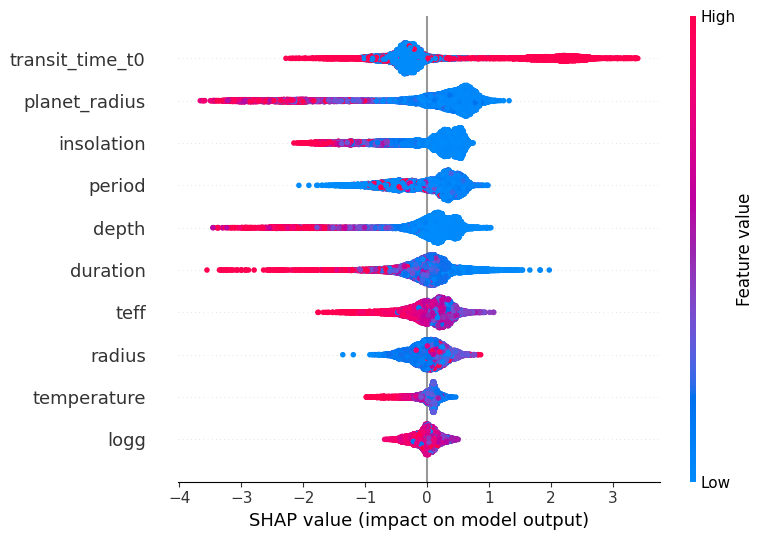

In [70]:
shap.summary_plot(shap_values, X_train_shap)

In [74]:
initjs()
SAMPLE_INDEX = 10 
shap.force_plot(explainer.expected_value, shap_values[SAMPLE_INDEX], X_train_shap.iloc[SAMPLE_INDEX])

NameError: name 'initjs' is not defined


--- PLOT 3: VALUE/IMPACT RELATIONSHIP (DEPENDENCE PLOT) for radius ---


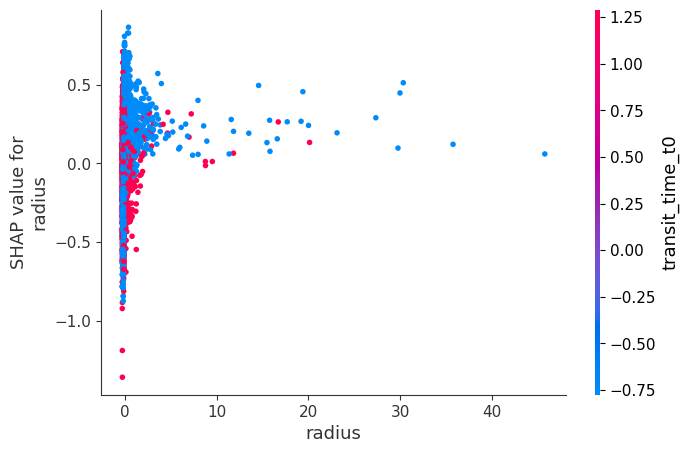

In [69]:
# c) Dependence Plot (Relationship between Value and Impact)
# Shows how a feature's value (e.g., koi_depth) affects the prediction.
FEATURE_TO_PLOT = "radius" # Or choose "koi_period", "koi_prad", etc.
shap.dependence_plot(FEATURE_TO_PLOT, shap_values, X_train_shap)

In [77]:
print(f"NumPy:         {np.__version__}")
print(f"Pandas:        {pd.__version__}")
# Usamos mpl para matplotlib ya que es el alias común para el módulo principal
print(f"Matplotlib:    {plt.__version__}") 
print(f"XGBoost:       {xgb.__version__}")
print(f"Scikit-learn:  {sklearn.__version__}")
print(f"Optuna:        {optuna.__version__}")
print(f"Seaborn:       {sns.__version__}")

NumPy:         1.26.4
Pandas:        2.2.3
Matplotlib:    3.7.2
XGBoost:       2.0.3
Scikit-learn:  1.2.2
Optuna:        4.4.0
Seaborn:       0.12.2
